## **Lanczos Filter**

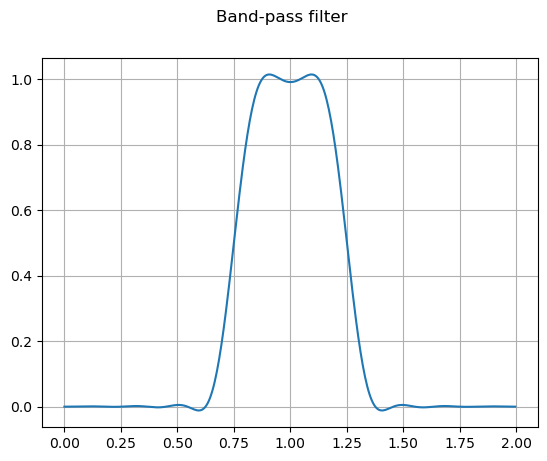

In [7]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.fft import fft, ifft, fftfreq

def lanczos_filter_bandpass(fc_lo, fc_up, n_weight, dT, duration):
    k = np.arange(1,n_weight+1,1)
    df = 1/duration
    f_nyquist = 1./(2*dT)
    # Normalize the cut off frequency with the Nyquist frequency
    fc_up_nomalized = fc_up/f_nyquist
    fcl_nomalized   = fc_lo/f_nyquist
    wk = (np.sin(np.pi*fc_up_nomalized*k) - np.sin(np.pi*fcl_nomalized*k) )/(np.pi*k) * (np.sin(np.pi*k/n_weight)/(np.pi*k/n_weight))
    freq_range = np.arange(0.0, f_nyquist, df)
    response_func = freq_range.copy()*.0
    i = 0
    # response function
    for f in freq_range:
        response_func[i] = (fc_up_nomalized - fcl_nomalized) + 2*np.sum(wk*np.cos(2*np.pi*f*k*dT))
        i = i + 1
    return freq_range, response_func

# define frequency range of interest
fc_lo = 0.75                        # lower cutoff frequency for bandpass filter
fc_up = 1.25                        # upper cutoff frequency for bandpass filter
n_weight = 21                       # number of weight
f_nyquist = 2                       # maximum frequency
dT = 1./(f_nyquist*2)               # sampling rate
duration = 200                      # duration of recording

[freq_range, response_func] = lanczos_filter_bandpass(fc_lo, fc_up, n_weight, dT, duration)
plt.plot(freq_range, response_func)
plt.suptitle("Band-pass filter")
plt.grid()

## **Applied for synthetic data**

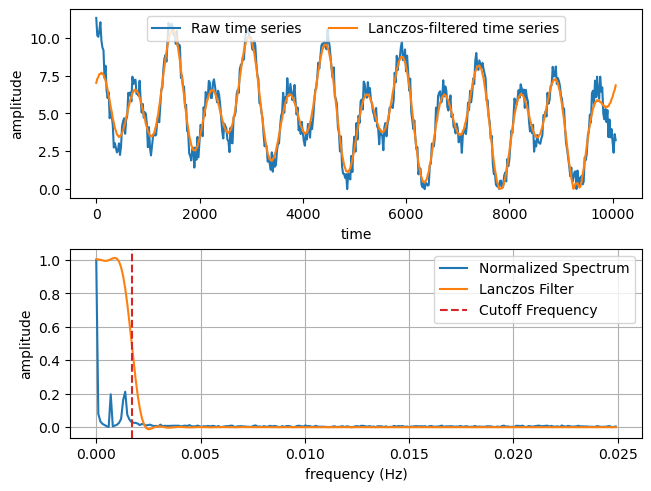

In [8]:
def synthetic_timeseries(t):
    T1 = 12.4*60
    T2 = 24*60
    T3 = 15*24*60
    pnoise = 0.30;
    yt = 5 + 3*np.cos(2*np.pi*t/T1) + 2*np.cos(2*np.pi*t/T2) + 1*np.cos(2*np.pi*t/T3)
    yt = yt + pnoise*max(yt-np.mean(yt))*(0.5 - np.random.rand(np.size(yt)))
    return yt

def timeseries_lanczos(fc_lo, fc_up, n_weight, dT, duration, t, yt):
    nsample = int(duration//dT)
    midpoint = nsample//2
    if nsample%2 == 1:
        midpoint = midpoint + 1
    xf = fftfreq(nsample, dT) [:midpoint]
    yf = fft(yt)

    # do filter
    freq_range, response_func = lanczos_filter_bandpass(fc_lo, fc_up, n_weight, dT, duration)
    yf_filter = yf.copy()
    yf_filter[:midpoint] = yf[:midpoint]*response_func
    if nsample%2 == 1:
        yf_filter[midpoint-1:len(yf)] = np.conj(yf_filter[(midpoint):0:-1])
    else:
        yf_filter[midpoint:len(yf)] = np.conj(yf_filter[(midpoint):0:-1])
    yt_nofilter = ifft(yf)
    yt_filter   = ifft(yf_filter)

    fig, axs = plt.subplots(2, layout="constrained")
    axs[0].plot(t, np.abs(yt_nofilter), label = "Raw time series")
    axs[0].plot(t, np.abs(yt_filter), label = "Lanczos-filtered time series")
    # axs[0].set_ylim([-2, 16])
    axs[0].set(xlabel='time', ylabel='amplitude')
    axs[0].legend(ncol=2, loc="upper center")

    # axs[1].plot(xf,2.0/nsample * np.abs(yf[0:midpoint]))
    axs[1].plot(xf,np.abs(yf[0:midpoint])/max(np.abs(yf[0:midpoint])), label = "Normalized Spectrum") # normalized
    axs[1].plot(freq_range, response_func, label = "Lanczos Filter")
    axs[1].axvline(fc_up, color='tab:red', ls='--', label = "Cutoff Frequency")
    axs[1].set(xlabel='frequency (Hz)', ylabel='amplitude')
    axs[1].legend()
    axs[1].grid()

# initial values
fc_lo = 0.000                               # lower cutoff frequency for bandpass filter
fc_up = 0.0017                              # upper cutoff frequency for bandpass filter
n_weight = 50                               # number of weight
dT = 20                                     # sampling rate
duration = 7*24*60                          # 7-day data
t = np.arange(0, duration, dT)
yt = synthetic_timeseries(t)

timeseries_lanczos(fc_lo, fc_up, n_weight, dT, duration, t, yt)

## **Applied for sample data**

In [9]:
data1 = np.genfromtxt("../datasets/sampledata.txt", usecols=0)
data2 = np.genfromtxt("../datasets/sampledata2.txt", usecols=0)
data3 = np.genfromtxt("../datasets/sampledata3.txt", usecols=3)
data4 = np.genfromtxt("../datasets/sampledata4.txt", usecols=3)

def modifyOutlier(data):
    """
    This function is used to process the errors in data
    The errors is found based on the outlier
    The ouliters are then modified by 
    """
    data1 = data.copy()
    p25 = np.percentile(data, 25)
    p75 = np.percentile(data, 75)
    iqr = p75 - p25
    maxOutlier = p75 + iqr*1.5
    minOutlier = p25 - iqr*1.5
    outList = np.append(np.where(minOutlier>data)[0],np.where(maxOutlier<data)[0])
    for i in outList:
        if i == len(data)-1:
            data1[i] = (data[i-1] + data[0])/2
        else:
            data1[i] = (data[i-1] + data[i+1])/2
    return (data1)

# remove abnormals
data3new = modifyOutlier(data3)
data4new = modifyOutlier(data4)

**Basic filter**

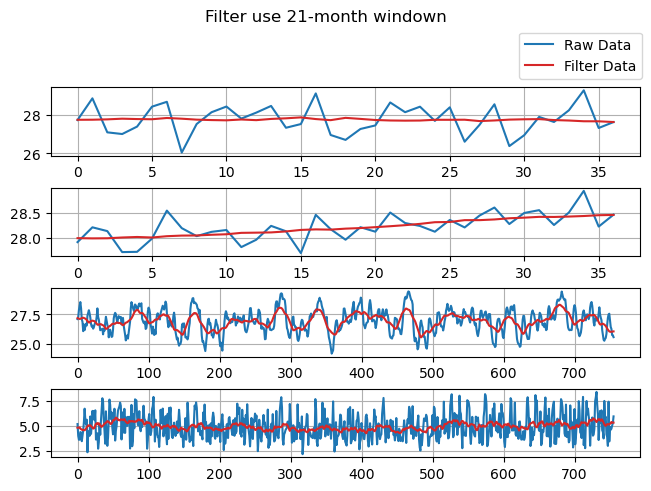

In [10]:
def basicfilter(data, n):
    # add zero value
    data = np.insert(data, 0, np.ones([n//2])*data[0])
    data = np.insert(data, len(data)-1, np.ones([n//2])*data[len(data)-1])
    x = np.zeros([len(data)])
    for i in range(-(n//2),(n//2)+1):
        x = np.roll(data, i) + x
    x = x/n
    return x[n//2:len(x)-n//2]

# use filter
data1_filter = basicfilter(data1,21)
data2_filter = basicfilter(data2,21)
data3new_filter = basicfilter(data3new,21)
data4new_filter = basicfilter(data4new,21)

fig, axs = plt.subplots(4, layout="constrained")
axs[0].plot(data1,'tab:blue',label = "Raw Data")
axs[0].plot(data1_filter,'tab:red',label = "Filter Data")
axs[0].legend(loc="upper right", ncol=1, bbox_to_anchor=(1.014, 1.9))
axs[1].plot(data2,'tab:blue',label = "Data 2")
axs[1].plot(data2_filter,'tab:red')
axs[2].plot(data3new,'tab:blue',label = "Data 3")
axs[2].plot(data3new_filter,'tab:red')
axs[3].plot(data4new,'tab:blue',label = "Data 4")
axs[3].plot(data4new_filter,'tab:red')
plt.suptitle("Filter use 21-month windown")
for i in range(4):
    axs[i].grid()

**40 month period - lanczos**

Text(0.5, 0.98, 'data 3')

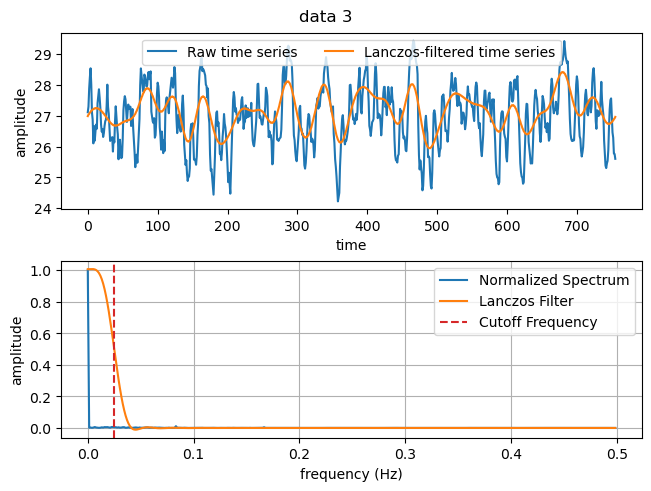

In [11]:
# define frequency range of interest
fc_lo = 0.00                    # lower cutoff frequency for bandpass filter
fc_up = 1/40                    # upper cutoff frequency for bandpass filter
n_weight = 41                   # number of weight
dT = 1.                         # sampling rate
duration = len(data3new)        # duration of recording
t = np.arange(.0, duration, dT)
yt = data3new.copy()
timeseries_lanczos(fc_lo, fc_up, n_weight, dT, duration, t, yt)
plt.suptitle("data 3")

Text(0.5, 0.98, 'data 4')

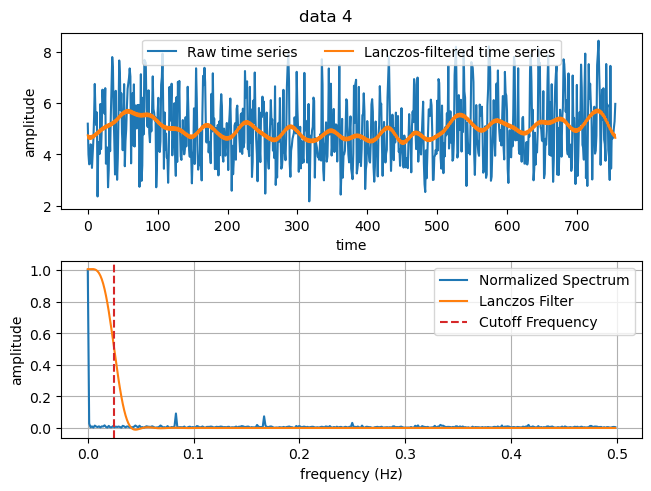

In [12]:
yt = data4new
timeseries_lanczos(fc_lo, fc_up, n_weight, dT, duration, t, yt)
plt.suptitle("data 4")